In [131]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

# 모델
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# 모델 평가 
from sklearn.metrics import (classification_report, confusion_matrix, roc_curve, 
                             auc, precision_recall_curve, accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, confusion_matrix)

from sklearn.model_selection import learning_curve

import pandas as pd

#### 함수들

In [132]:
# 분류기 성능 return
def get_clf_eval(y_test, pred):
    acc = accuracy_score(y_test, pred)
    pre = precision_score(y_test, pred)
    re = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    auc = roc_auc_score(y_test, pred)

    return acc, pre, re, f1, auc

# 성능 출력
def print_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    acc, pre, re, f1, auc = get_clf_eval(y_test, pred)

    print('=> confusion matrix')
    print(confusion)
    print('======================')

    print('Accuracy: {0:.4f}, Precision: {1:.4f}'.format(acc, pre))
    print('Recall: {0:.4f}, F1: {1:.4f}, AUC: {2:.4f}'.format(re, f1, auc))

# 모델과 데이터를 주면 성능 출력
def get_result(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)

    return get_clf_eval(y_test, pred)

# 다수의 모델의 성능을 정리해어 df으로 반환
def get_result_pd(models, model_names, X_train, y_train, X_test, y_test):
    col_names = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    tmp = []

    for model in models:
        tmp.append(get_result(model, X_train, y_train, X_test, y_test))

    return pd.DataFrame(tmp, columns=col_names, index=model_names)

import matplotlib.pyplot as plt

def draw_roc_curve(models, model_names, X_test, y_test):
    plt.figure(figsize=(10, 10))

    for model in range(len(models)):
        pred = models[model].predict_proba(X_test)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_test, pred)
        plt.plot(fpr, tpr, label=model_names[model])

    plt.plot([0, 1], [0, 1], 'k--', label='random guess')
    plt.title('ROC')
    plt.legend()
    plt.grid()
    plt.show()

# 1. 데이터 준비

In [133]:
import pandas as pd
import numpy as np

data = pd.read_csv('./CVD_cleaned.csv')

data.loc[(data['Age_Category']=='18-24') | (data['Age_Category']=='25-29'), 'Age_Category'] = '18-29'
data.loc[(data['Age_Category']=='30-34') | (data['Age_Category']=='35-39'), 'Age_Category'] = '30-39'
data.loc[(data['Age_Category']=='40-44') | (data['Age_Category']=='45-49'), 'Age_Category'] = '40-49'
data.loc[(data['Age_Category']=='50-54') | (data['Age_Category']=='55-59'), 'Age_Category'] = '50-59'
data.loc[(data['Age_Category']=='60-64') | (data['Age_Category']=='65-69'), 'Age_Category'] = '60-69'
data.loc[(data['Age_Category']=='70-74') | (data['Age_Category']=='75-79'), 'Age_Category'] = '70-79'

# 2. outlier 제거
- 일단 BMI outlier만 제거

In [134]:
# outlier를 제거할 column
selected_columns = ['BMI']

# IQR 계산
Q1 = data[selected_columns].quantile(0.25)
Q3 = data[selected_columns].quantile(0.75)
IQR = Q3 - Q1

# weight
threshold = 2.5

outlier_mask = (
    (data[selected_columns] < (Q1 - threshold * IQR)) |
    (data[selected_columns] > (Q3 + threshold * IQR))
).any(axis=1)

# outlier 제거
data_nooutlier = data[~outlier_mask]

# Print the number of rows removed
num_rows_removed = len(data) - len(data_nooutlier)
print(f"제거된 ourlier count: {num_rows_removed}")

제거된 ourlier count: 2401


# 3. 인코딩

In [135]:
# 성별 원핫인코딩
data_nooutlier = pd.get_dummies(data_nooutlier, columns=['Sex'])
sex_columns = ['Sex_Female', 'Sex_Male']
for column in sex_columns:
    data_nooutlier[column] = data_nooutlier[column].map({True: 1, False: 0})

# Yes, No -> 1, 0
binary_columns = ['Heart_Disease', 'Skin_Cancer', 'Other_Cancer', 
                  'Depression', 'Arthritis', 'Smoking_History','Exercise']

# diabetes
diabetes_mapping = {
    'No': 0,
    'No, pre-diabetes or borderline diabetes': 0, 
    'Yes, but female told only during pregnancy': 1,
    'Yes': 1
}
data_nooutlier['Diabetes'] = data_nooutlier['Diabetes'].map(diabetes_mapping)

# Heart_Disease, Skin_Cancer, Other_Cancer, Depression, Arthritis, Smoking_History, Exercise
for column in binary_columns:
    data_nooutlier[column] = data_nooutlier[column].map({'Yes': 1, 'No': 0})

# General_Health, Checkup, Age_Category
general_health_mapping = {
    'Poor': 0,
    'Fair': 1,
    'Good': 2,
    'Very Good': 3,
    'Excellent': 4
}

data_nooutlier['General_Health'] = data_nooutlier['General_Health'].map(general_health_mapping)

checkup_mapping = {
    'Never': 0,
    '5 or more years ago': 1,
    'Within the past 5 years': 2,
    'Within the past 2 years': 3,
    'Within the past year': 4
    
}
data_nooutlier['Checkup'] = data_nooutlier['Checkup'].map(checkup_mapping)

# {'18-29', '30-39', '40-49', '50-59', '60-69', '75-79', '80+'}
age_category_mapping = {
    '18-29': 0,
    '30-39': 1,
    '40-49': 2,
    '50-59': 3,
    '60-69': 4,
    '70-79': 5,
    '80+': 6
}
data_nooutlier['Age_Category'] = data_nooutlier['Age_Category'].map(age_category_mapping)    

data_nooutlier.head()

,General_Health,Checkup,Exercise,Heart_Disease,Skin_Cancer,Other_Cancer,Depression,Diabetes,Arthritis,Age_Category,Height_(cm),Weight_(kg),BMI,Smoking_History,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption,Sex_Female,Sex_Male
0,0,3,0,0,0,0,0,0,1,5,150.0,32.66,14.54,1,0.0,30.0,16.0,12.0,1,0
1,3,4,0,1,0,0,0,1,0,5,165.0,77.11,28.29,0,0.0,30.0,0.0,4.0,1,0
2,3,4,1,0,0,0,0,1,0,4,163.0,88.45,33.47,0,4.0,12.0,3.0,16.0,1,0
3,0,4,1,1,0,0,0,1,0,5,180.0,93.44,28.73,0,0.0,30.0,30.0,8.0,0,1
4,2,4,0,0,0,0,0,0,0,6,191.0,88.45,24.37,1,0.0,8.0,4.0,0.0,0,1


# 3. Trial 1
- BMI outlier 제거
- **모든 column 학습**
- resample: X
- scaler: StandardScaler
- GridSearch: X

## (1) Train test split

In [136]:
X = data_nooutlier.drop("Heart_Disease", axis = 1)
y = data_nooutlier['Heart_Disease']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=13, stratify=y)

## (2) Resample

## (3) Scaling

In [137]:
scaler = StandardScaler()

scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## (4) Model

### 1 Logistic Regression

=> confusion matrix
[[61902 22611]
 [ 1573  5850]]
Accuracy: 0.7369, Precision: 0.2055
Recall: 0.7881, F1: 0.3261, AUC: 0.7603


=> classification_report

              precision    recall  f1-score   support

           0       0.98      0.73      0.84     84513
           1       0.21      0.79      0.33      7423

    accuracy                           0.74     91936
   macro avg       0.59      0.76      0.58     91936
weighted avg       0.91      0.74      0.80     91936



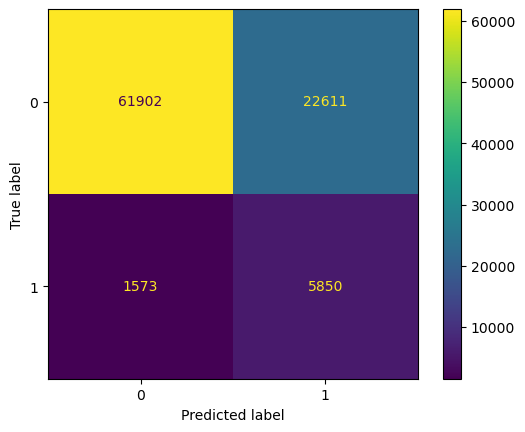

In [138]:
# LR
lr_clf = LogisticRegression(random_state=13, 
                            class_weight='balanced',
                            solver='liblinear')
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)

print_clf_eval(y_test, lr_pred)

print('\n\n=> classification_report\n')
print(classification_report(y_test, lr_pred))

cm = confusion_matrix(y_test, lr_pred, labels=lr_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr_clf.classes_)

disp.plot()
plt.show()

### 2 Decision Tree

=> confusion matrix
[[57433 27080]
 [ 1351  6072]]
Accuracy: 0.6908, Precision: 0.1832
Recall: 0.8180, F1: 0.2993, AUC: 0.7488


=> classification_report

              precision    recall  f1-score   support

           0       0.98      0.68      0.80     84513
           1       0.18      0.82      0.30      7423

    accuracy                           0.69     91936
   macro avg       0.58      0.75      0.55     91936
weighted avg       0.91      0.69      0.76     91936



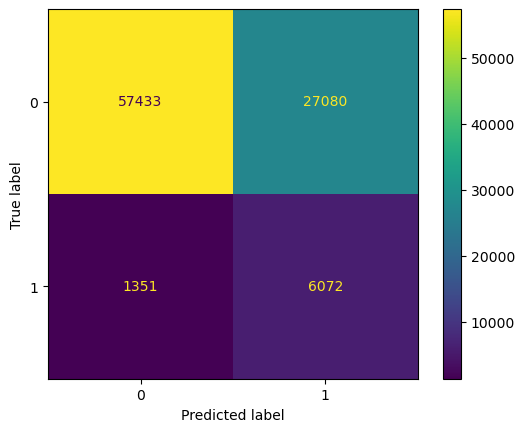

In [139]:
# DT
dt_clf = DecisionTreeClassifier(random_state=13, 
                                class_weight='balanced',
                                max_depth=4)
dt_clf.fit(X_train, y_train)
dt_pred = dt_clf.predict(X_test)

print_clf_eval(y_test, dt_pred)

print('\n\n=> classification_report\n')
print(classification_report(y_test, dt_pred))

cm = confusion_matrix(y_test, dt_pred, labels=dt_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dt_clf.classes_)

disp.plot()
plt.show()

### 3 Random Forest

=> confusion matrix
[[62153 22360]
 [ 1647  5776]]
Accuracy: 0.7389, Precision: 0.2053
Recall: 0.7781, F1: 0.3249, AUC: 0.7568


=> classification_report

              precision    recall  f1-score   support

           0       0.97      0.74      0.84     84513
           1       0.21      0.78      0.32      7423

    accuracy                           0.74     91936
   macro avg       0.59      0.76      0.58     91936
weighted avg       0.91      0.74      0.80     91936



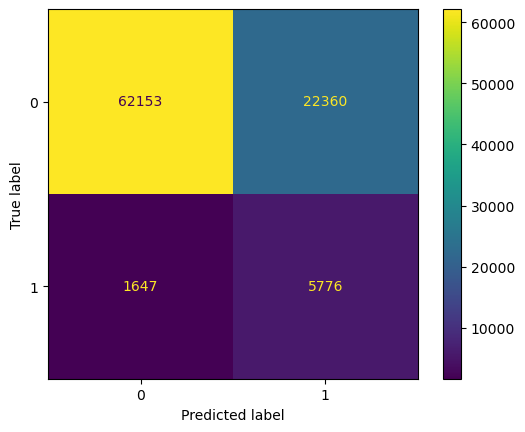

In [140]:
# RF
rf_clf = RandomForestClassifier(random_state=13, 
                                n_estimators=50,
                                max_depth=10,
                                min_samples_leaf=12,
                                min_samples_split=12,
                                n_jobs=-1,
                                class_weight='balanced')
rf_clf.fit(X_train, y_train)
rf_pred = rf_clf.predict(X_test)

print_clf_eval(y_test, rf_pred)

print('\n\n=> classification_report\n')
print(classification_report(y_test, rf_pred))

cm = confusion_matrix(y_test, rf_pred, labels=rf_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_clf.classes_)

disp.plot()
plt.show()

### 4 LGBM

=> confusion matrix
[[69143 15370]
 [ 2824  4599]]
Accuracy: 0.8021, Precision: 0.2303
Recall: 0.6196, F1: 0.3358, AUC: 0.7188


=> classification_report

              precision    recall  f1-score   support

           0       0.96      0.82      0.88     84513
           1       0.23      0.62      0.34      7423

    accuracy                           0.80     91936
   macro avg       0.60      0.72      0.61     91936
weighted avg       0.90      0.80      0.84     91936



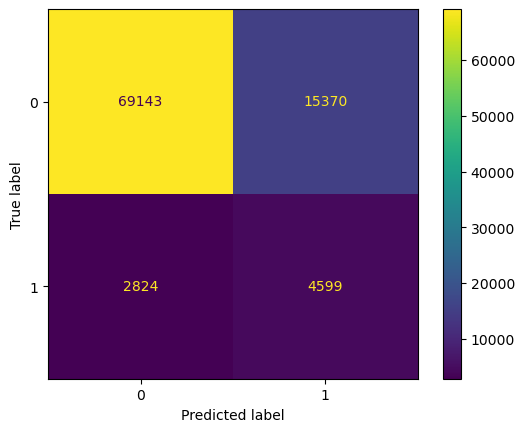

In [141]:
# LGBM
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, 
                            boost_from_average=False,
                            class_weight='balanced')
lgbm_clf.fit(X_train, y_train)
lgbm_pred = lgbm_clf.predict(X_test)

print_clf_eval(y_test, lgbm_pred)

print('\n\n=> classification_report\n')
print(classification_report(y_test, lgbm_pred))

cm = confusion_matrix(y_test, lgbm_pred, labels=lgbm_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lgbm_clf.classes_)

disp.plot()
plt.show()

### 5 XGBoost

=> confusion matrix
[[61190 23323]
 [ 1487  5936]]
Accuracy: 0.7301, Precision: 0.2029
Recall: 0.7997, F1: 0.3236, AUC: 0.7619


=> classification_report

              precision    recall  f1-score   support

           0       0.98      0.72      0.83     84513
           1       0.20      0.80      0.32      7423

    accuracy                           0.73     91936
   macro avg       0.59      0.76      0.58     91936
weighted avg       0.91      0.73      0.79     91936



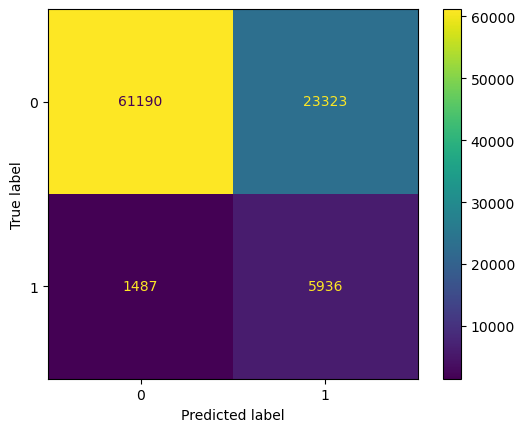

In [142]:
xgb_clf = XGBClassifier(
    scale_pos_weight=sum(y_train==0)/sum(y_train==1),
    n_estimators=400,
    learning_rate=0.1, max_depth=3
)

xgb_clf.fit(X_train, y_train)
xgb_pred = xgb_clf.predict(X_test)

print_clf_eval(y_test, xgb_pred)

print('\n\n=> classification_report\n')
print(classification_report(y_test, xgb_pred))

cm = confusion_matrix(y_test, xgb_pred, labels=xgb_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_clf.classes_)

disp.plot()
plt.show()

## (5) 정리

In [143]:
models = [lr_clf, dt_clf, rf_clf, lgbm_clf, xgb_clf]
model_names = ['LogisticRegression', 'DecisionTree', 'RandomForest', 'LightGBM', 'XGBoost']

result = get_result_pd(models, model_names, X_train, y_train, X_test, y_test)

In [144]:
result

,accuracy,precision,recall,f1,roc_auc
LogisticRegression,0.736947,0.205544,0.788091,0.326051,0.760273
DecisionTree,0.690752,0.183156,0.817998,0.299298,0.748787
RandomForest,0.738873,0.205289,0.778122,0.324869,0.756774
LightGBM,0.802101,0.230307,0.619561,0.335791,0.718848
XGBoost,0.730138,0.202878,0.799677,0.323646,0.761854


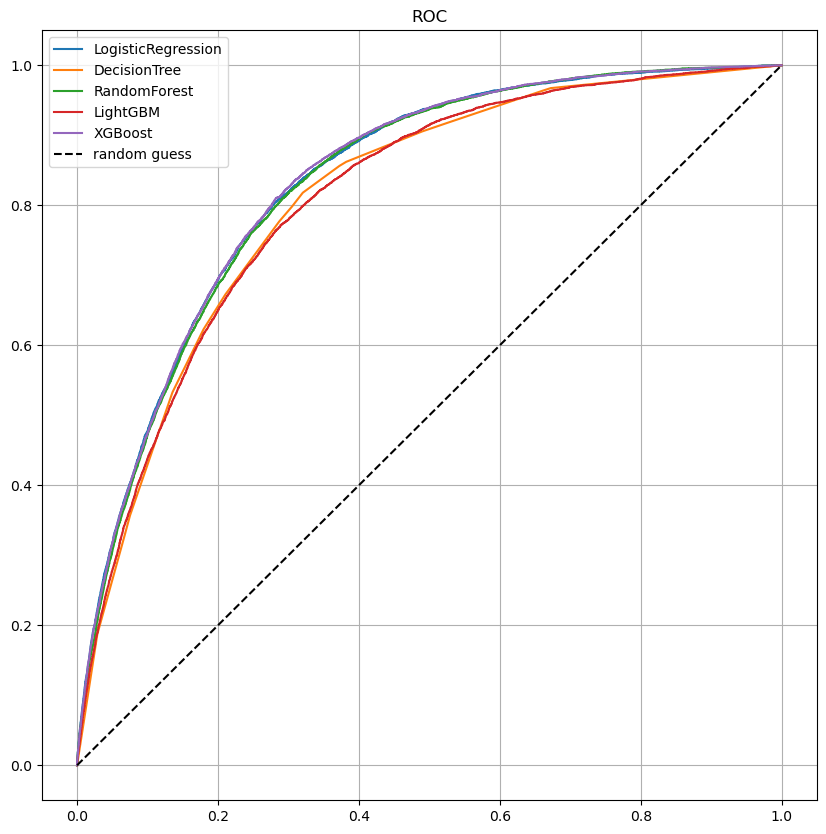

In [145]:
draw_roc_curve(models, model_names, X_test, y_test)

# 5. Trial 2
- BMI outlier 제거
- **상관관계 절댓값 0.1 이상 column 학습**
- resample: X
- scaler: StandardScaler
- GridSearch: O

## (1) Train test split

In [146]:
data_trial2 = data_nooutlier[['Heart_Disease', 'Diabetes', 'Arthritis', 'Age_Category', 
                             'Smoking_History', 'General_Health']]

In [147]:
X = data_trial2.drop("Heart_Disease", axis = 1)
y = data_trial2['Heart_Disease']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=13, stratify=y)

## (2) Resample

## (3) Scaler

In [148]:
scaler = StandardScaler()

scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## (4) Model

### 1 Logistic Regression

=> confusion matrix
[[61715 22798]
 [ 1760  5663]]
Accuracy: 0.7329, Precision: 0.1990
Recall: 0.7629, F1: 0.3156, AUC: 0.7466


=> classification_report

              precision    recall  f1-score   support

           0       0.97      0.73      0.83     84513
           1       0.20      0.76      0.32      7423

    accuracy                           0.73     91936
   macro avg       0.59      0.75      0.57     91936
weighted avg       0.91      0.73      0.79     91936



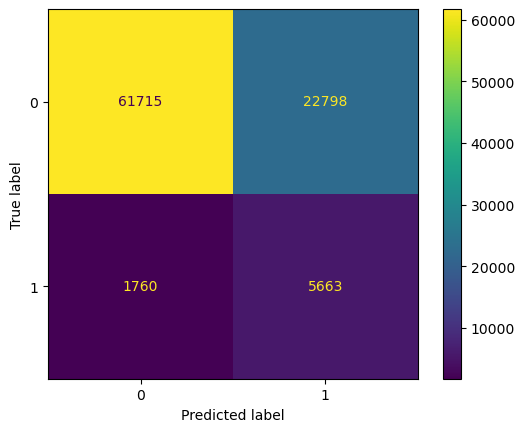

In [149]:
# LR
lr_clf = LogisticRegression(random_state=13, 
                            class_weight='balanced',
                            solver='liblinear')
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)

print_clf_eval(y_test, lr_pred)

print('\n\n=> classification_report\n')
print(classification_report(y_test, lr_pred))

cm = confusion_matrix(y_test, lr_pred, labels=lr_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr_clf.classes_)

disp.plot()
plt.show()

### 2 Decision Tree

=> confusion matrix
[[52724 31789]
 [ 1077  6346]]
Accuracy: 0.6425, Precision: 0.1664
Recall: 0.8549, F1: 0.2786, AUC: 0.7394


=> classification_report

              precision    recall  f1-score   support

           0       0.98      0.62      0.76     84513
           1       0.17      0.85      0.28      7423

    accuracy                           0.64     91936
   macro avg       0.57      0.74      0.52     91936
weighted avg       0.91      0.64      0.72     91936



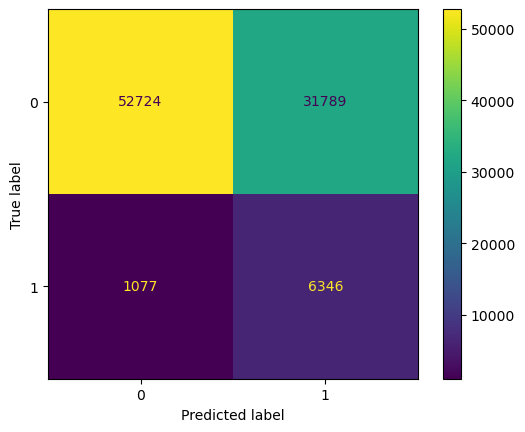

In [150]:
# DT
dt_clf = DecisionTreeClassifier(random_state=13, 
                                class_weight='balanced',
                                max_depth=4)
dt_clf.fit(X_train, y_train)
dt_pred = dt_clf.predict(X_test)

print_clf_eval(y_test, dt_pred)

print('\n\n=> classification_report\n')
print(classification_report(y_test, dt_pred))

cm = confusion_matrix(y_test, dt_pred, labels=dt_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dt_clf.classes_)

disp.plot()
plt.show()

### 3 Random Forest

=> confusion matrix
[[60347 24166]
 [ 1647  5776]]
Accuracy: 0.7192, Precision: 0.1929
Recall: 0.7781, F1: 0.3092, AUC: 0.7461


=> classification_report

              precision    recall  f1-score   support

           0       0.97      0.71      0.82     84513
           1       0.19      0.78      0.31      7423

    accuracy                           0.72     91936
   macro avg       0.58      0.75      0.57     91936
weighted avg       0.91      0.72      0.78     91936



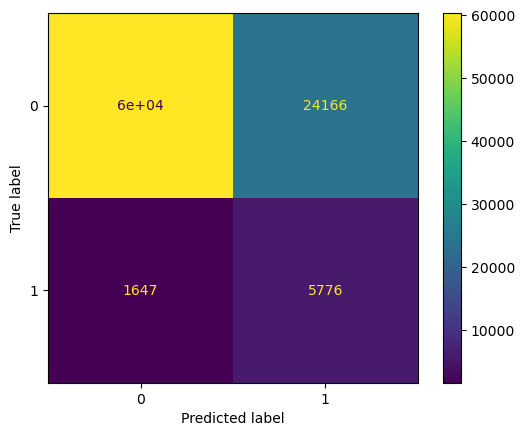

In [151]:
# RF
rf_clf = RandomForestClassifier(random_state=13, 
                                n_estimators=50,
                                max_depth=10,
                                min_samples_leaf=12,
                                min_samples_split=12,
                                n_jobs=-1,
                                class_weight='balanced')
rf_clf.fit(X_train, y_train)
rf_pred = rf_clf.predict(X_test)

print_clf_eval(y_test, rf_pred)

print('\n\n=> classification_report\n')
print(classification_report(y_test, rf_pred))

cm = confusion_matrix(y_test, rf_pred, labels=rf_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_clf.classes_)

disp.plot()
plt.show()

### 4 LGBM

=> confusion matrix
[[60293 24220]
 [ 1645  5778]]
Accuracy: 0.7187, Precision: 0.1926
Recall: 0.7784, F1: 0.3088, AUC: 0.7459


=> classification_report

              precision    recall  f1-score   support

           0       0.97      0.71      0.82     84513
           1       0.19      0.78      0.31      7423

    accuracy                           0.72     91936
   macro avg       0.58      0.75      0.57     91936
weighted avg       0.91      0.72      0.78     91936



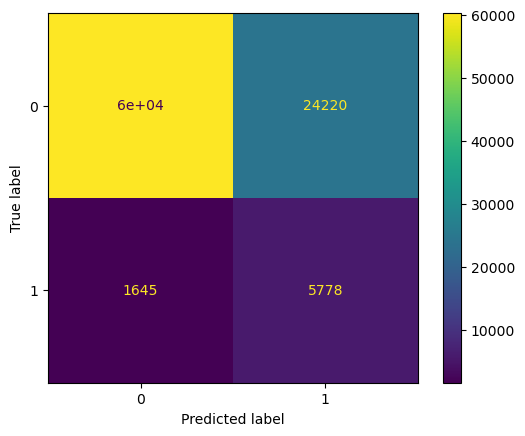

In [152]:
# LGBM
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, 
                            boost_from_average=False,
                            class_weight='balanced')
lgbm_clf.fit(X_train, y_train)
lgbm_pred = lgbm_clf.predict(X_test)

print_clf_eval(y_test, lgbm_pred)

print('\n\n=> classification_report\n')
print(classification_report(y_test, lgbm_pred))

cm = confusion_matrix(y_test, lgbm_pred, labels=lgbm_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lgbm_clf.classes_)

disp.plot()
plt.show()

### 5 XGBoost

=> confusion matrix
[[60265 24248]
 [ 1621  5802]]
Accuracy: 0.7186, Precision: 0.1931
Recall: 0.7816, F1: 0.3097, AUC: 0.7474


=> classification_report

              precision    recall  f1-score   support

           0       0.97      0.71      0.82     84513
           1       0.19      0.78      0.31      7423

    accuracy                           0.72     91936
   macro avg       0.58      0.75      0.57     91936
weighted avg       0.91      0.72      0.78     91936



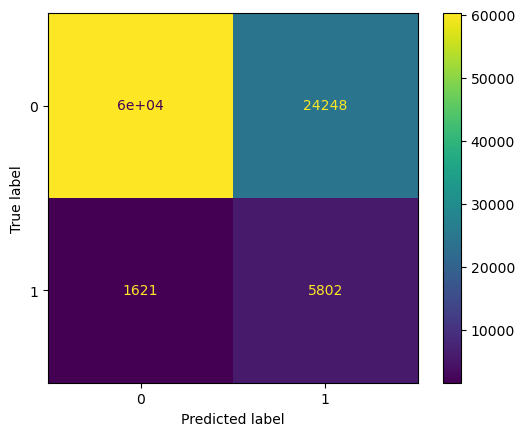

In [153]:
xgb_clf = XGBClassifier(
    scale_pos_weight=sum(y_train==0)/sum(y_train==1),
    n_estimators=400,
    learning_rate=0.1, max_depth=3
)

xgb_clf.fit(X_train, y_train)
xgb_pred = xgb_clf.predict(X_test)

print_clf_eval(y_test, xgb_pred)

print('\n\n=> classification_report\n')
print(classification_report(y_test, xgb_pred))

cm = confusion_matrix(y_test, xgb_pred, labels=xgb_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_clf.classes_)

disp.plot()
plt.show()

## (5) 정리

In [154]:
models = [lr_clf, dt_clf, rf_clf, lgbm_clf, xgb_clf]
model_names = ['LogisticRegression', 'DecisionTree', 'RandomForest', 'LightGBM', 'XGBoost']

result = get_result_pd(models, model_names, X_train, y_train, X_test, y_test)

In [155]:
result

,accuracy,precision,recall,f1,roc_auc
LogisticRegression,0.732879,0.198974,0.762899,0.315628,0.746571
DecisionTree,0.642512,0.166409,0.854910,0.278590,0.739384
RandomForest,0.719229,0.192906,0.778122,0.309166,0.746089
LightGBM,0.718663,0.192613,0.778391,0.308811,0.745904
XGBoost,0.718619,0.193078,0.781625,0.309663,0.747355


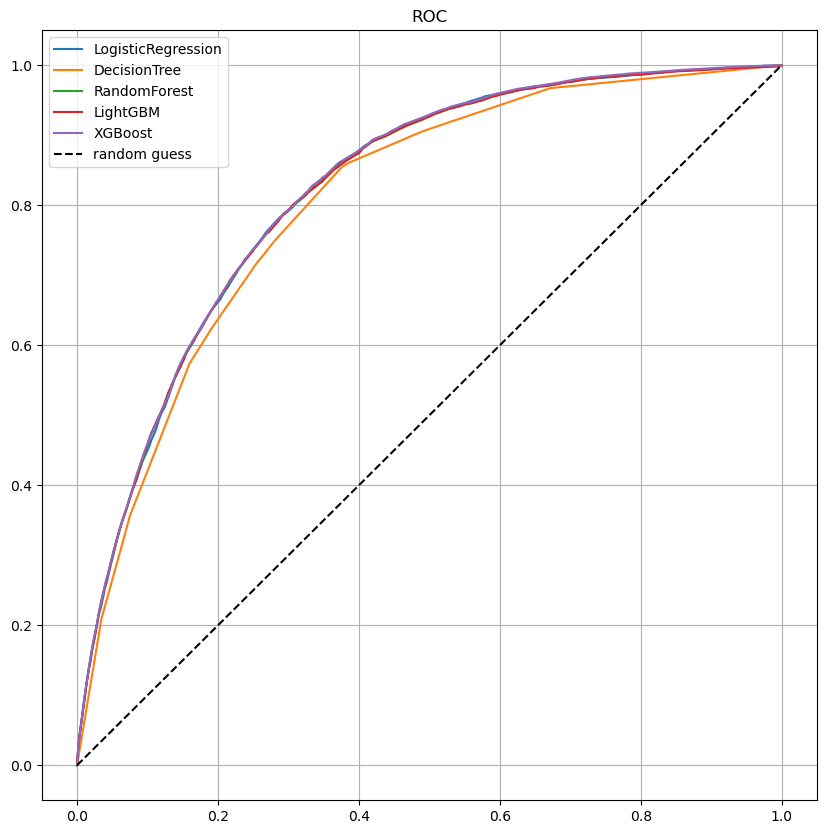

In [156]:
draw_roc_curve(models, model_names, X_test, y_test)

#### 디카프리오와 윈슬렛 심장병 예측 - Trial 2에서 accuracy 높은 logistic regression

In [163]:
# 디카프리오 data 특정하기
dicaprio = np.array([[0, 0, 0, 1, 4]])  
print('Dicaprio: ', lr_clf.predict_proba(dicaprio)[0, 1])

Dicaprio:  0.042416542926691156


In [161]:
# winslet data 특정하기
winslet = np.array([[0, 0, 0, 0, 3]])  
print('Winslet: ', lr_clf.predict_proba(winslet)[0, 1])

Winslet:  0.06228425112960196
